# Check Goat coordinates
## Check goat coordinates with data provided by Goat genome project
Test coordinates received from goat genome consortium

* [Working on CHI1](#working-on-chi1)
* [Working on ARS1](#working-on-ars1)
    - [Check mismatches with ensembl](#check-mismatches-with-ensembl)


Setting up stuff

In [1]:
import csv
import json
import pprint
import random
import pandas
import functools
import matplotlib.pyplot as plt

from collections import namedtuple, defaultdict
from itertools import islice
from ensemblrest import EnsemblRest
from Bio import Entrez
from Bio import SeqIO
from BioSQL import BioSeqDatabase

from src.data.common import WORKING_ASSEMBLIES
from src.features.utils import get_project_dir, text_or_gzip_open, sanitize, get_interim_dir
from src.features.smarterdb import global_connection, VariantGoat

# Always tell NCBI who you are
Entrez.email = "paolo.cozzi@ibba.cnr.it"

# define ensemblrest helper
ensRest = EnsemblRest()

# define the source data file
data_dir = get_project_dir() / "data/external/GOA/CONSORTIUM"
capri_all_data = data_dir / "capri4dbsnp-base-CHI-ARS-OAR-UMD.csv.gz"

# define the NCBI database local file
ncbi_database = get_project_dir() / "data/external/GOA/NCBI/biosqldb-goat.sqlite3"
ncbi_conn = BioSeqDatabase.open_database(driver='sqlite3', db=ncbi_database)

# make a connection to smarter database
global_connection()

# get the smarter assembly I want to test
CHI1 = WORKING_ASSEMBLIES['CHI1']

# define a folder in which put all results of such explorative analyses:
result_dir = get_interim_dir() / "issue-18"
result_dir.mkdir(parents=True, exist_ok=True)

Defining some useful functions. *CHI1* chromosomes are not numeric, but uses NCBI ids:

In [2]:
@functools.lru_cache(maxsize=1000)
def get_chr_from_ncbi(chrom_name: str, conn: BioSeqDatabase.DBServer):
    """This function convert the NCBI id to a chromosome id. Data is
    collected using eutils, recorded in a sqlite database and cached
    with lru_cache. When asking for a chromosome already requested
    the cached or datbase copy is returned, instead of doing another
    NCBI query"""
    
    # get rid of the cases not managed by ncbi nucleotide
    if chrom_name == 'null':
        return None
    
    if chrom_name.isdigit():
        return chrom_name
    
    # if db doesn't exists, conn.new_database("goat")
    db = conn["goat"]
    
    try:
        record = db.lookup(primary_id=chrom_name)
        
    except IndexError:
        # get data from NCBI
        with Entrez.efetch(db="nucleotide", id=chrom_name, rettype="gb", retmode="text") as handle:
            record = SeqIO.parse(handle, "genbank")
            # write data to db
            db.load(record)
            conn.commit()
            record = db.lookup(primary_id=chrom_name)
        
    return record.features[0].qualifiers["chromosome"][0]


def check_coordinates_chi1(record, variant):
    """A method to check coordinates by selecting the 
    proper columns from a CSV record"""
    
    check = True
    location = variant.locations[0]
    
    # ['chi_1_0_chr', 'chi_1_0_pos', 'chi_1_0_strand']
    if record.chi_1_0_chr != location.chrom:
        check = False
        
    if record.chi_1_0_pos != location.position:
        check = False
        
    return check


def search_mismatches(datafile, smarter_assembly, check_coordinates):    
    # track mismatches in positions
    mismatches = []

    # track missing sps
    missing = []

    with text_or_gzip_open(datafile) as handle:
        reader = csv.reader(handle, delimiter="\t")
        header = next(reader)
        header = [sanitize(col) for col in header]
        Record = namedtuple("Record", header)
        for line in reader:
            # fix position columns
            for field in filter(lambda field: 'pos' in field, header):
                try:
                    idx = header.index(field)
                    line[idx] = int(line[idx])

                except ValueError as exc:
                    continue

            # fix chi1 chrom names
            idx = header.index('chi_1_0_chr')
            line[idx] = get_chr_from_ncbi(line[idx], ncbi_conn)

            # fix ars1 chrom_name
            idx = header.index('ars1_chr')
            line[idx] = get_chr_from_ncbi(line[idx], ncbi_conn)
            
            # make a record from csv line
            record = Record._make(line)

            # get variant and chosen location from database
            try:
                variant = VariantGoat.objects(name=record.locus_name).fields(
                    pk=0, rs_id=1, name=1, elemMatch__locations=smarter_assembly._asdict()).get()
                
            except VariantGoat.DoesNotExist:
                # print(f"Couldn't find variant {record.locus_name}")
                missing.append(record)
                continue

            # check data
            if not check_coordinates(record, variant):
                # print(f"Variant is different: {record} <> {variant}, {variant.locations[0]}")
                mismatches.append([record, variant])

    # print(record)
    # pprint.pprint(json.loads(variant.to_json()))
    print(f"There are {len(mismatches)} mismatches")
    print(f"{len(missing)} SNPs are not in database")
    
    return mismatches, missing

<a id='working-on-chi1'></a>
## Working on CHI1
Now check *CHI1* coordinates:

In [3]:
mismatches_chi1, missing_chi1 = search_mismatches(capri_all_data, CHI1, check_coordinates_chi1)

There are 1420 mismatches
6653 SNPs are not in database


Ok try to save missing mismatches between coordinates in a file:

In [4]:
with open(result_dir / "iggc_vs_smarter-mismatches-chi1.csv", "w") as handle:
    writer = csv.writer(handle, delimiter=",", lineterminator="\n")
    header = ['name', 'iggc_chr', 'iggc_pos', 'smarter_chr', 'smarter_pos']
    writer.writerow(header)
    
    for [record, variant] in mismatches_chi1:
        line = [record.locus_name, record.chi_1_0_chr, record.chi_1_0_pos, variant.locations[0].chrom, variant.locations[0].position]
        writer.writerow(line)
        
with open(result_dir / "iggc-missing_snps-chi1.csv", "w") as handle:
    writer = csv.writer(handle, delimiter=",", lineterminator="\n")
    header = ["name", "iggc_chr", "iggc_pos"]
    writer.writerow(header)
    
    for record in missing_chi1:
        line = [record.locus_name, record.chi_1_0_chr, record.chi_1_0_pos]
        writer.writerow(line)

Try to draw a picture of missing and mismatches SNP with the SNPs with no problems:

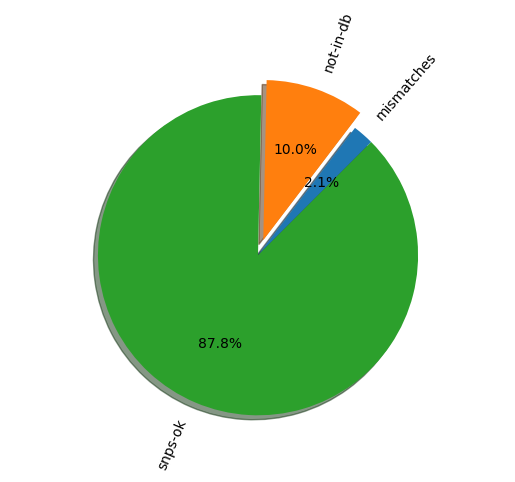

In [5]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['mismatches', 'not-in-db', 'snps-ok']
sizes = [len(mismatches_chi1), len(missing_chi1), VariantGoat.objects.count()-len(mismatches_chi1)]
explode = (0, 0.1, 0)  # only "explode" the 2nd slice (i.e. 'Not-in-db')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=45, rotatelabels=45)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Get some samples from missing and mismatches SNPs. The full list of those are written in a CSV file:

In [6]:
print("Get some missing SNPs as an example:")
random.seed(a=42, version=2)
print([record.locus_name for record in random.sample(missing_chi1, 20)])

Get some missing SNPs as an example:
['snp53232-scaffold802-302292', 'snp8623-scaffold131-1957741', 'snp2142-scaffold1065-346259', 'snp57899-scaffold937-945284', 'snp22751-scaffold2269-23307', 'snp20886-scaffold205-1652913', 'snp19319-scaffold1951-805', 'snp11414-scaffold1413-197984', 'snp57720-scaffold93-372964', 'snp7830-scaffold1281-1591810', 'snp55420-scaffold858-1840765', 'snp57833-scaffold932-648576', 'snp45755-scaffold628-186886', 'snp6063-scaffold1214-225045', 'snp49844-scaffold711-2905467', 'snp34187-scaffold401-1192271', 'snp2887-scaffold1086-820658', 'snp2545-scaffold1074-1086687', 'snp6823-scaffold125-1330098', 'snp19054-scaffold1912-898736']


In [7]:
random.seed(a=42, version=2)
selected_chi1 = random.sample(mismatches_chi1, 20)

In [8]:
data = defaultdict(list)

for record, variant in selected_chi1:
    data["locus_name"].append(record.locus_name)
    data["rs_"].append(record.rs_)
    data["chi_1_0_chr"].append(record.chi_1_0_chr)
    data["chi_1_0_pos"].append(record.chi_1_0_pos)
    data["rs_ids"].append(",".join(variant.rs_id))
    data["smarter_chrom"].append(variant.locations[0].chrom)
    data["smarter_pos"].append(variant.locations[0].position)

pandas.DataFrame.from_dict(data)

,locus_name,rs_,chi_1_0_chr,chi_1_0_pos,rs_ids,smarter_chrom,smarter_pos
0,snp53417-scaffold807-74773,rs268285051,Unknown,74773,rs268285051,0,0
1,snp10135-scaffold1361-44576,rs268243008,Unknown,44576,rs268243008,0,0
2,snp2042-scaffold1061-20259,rs268235116,Unknown,20259,rs268235116,0,0
3,snp21860-scaffold2144-53078,rs268254327,Unknown,53078,rs268254327,0,0
4,snp19559-scaffold1971-21103,rs268252089,Unknown,21103,rs268252089,0,0
5,snp18430-scaffold1867-78532,rs268251028,Unknown,78532,rs268251028,0,0
6,snp13189-scaffold1505-57602,rs268245970,Unknown,57602,rs268245970,0,0
7,snp6785-scaffold1249-70584,rs268239737,Unknown,70584,rs268239737,0,0
8,snp59632-scaffold985-45095,rs268291047,Unknown,45095,rs268291047,0,0
9,snp37483-scaffold4582-6164,rs268269564,Unknown,6164,rs268269564,0,0


Coordinates seems to match with database for *CHI1* assembly. Differences are in contigs (unknown chromosomes). What about missing snps? They are not defined in chip

<a id='working-on-ars1'></a>
## Working with ARS1
Checking latest coordinates version

In [9]:
# get the smarter assembly I want to test
ARS1 = WORKING_ASSEMBLIES['ARS1']

# defining a new function to test coordinates
def check_coordinates_ars1(record, variant):
    check = True
    location = variant.locations[0]
    
    # ['ars1_chr', 'ars1_pos', 'ars1_strand']
    if record.ars1_chr != location.chrom:
        check = False
        
    if record.ars1_pos != location.position:
        check = False
        
    return check

Search mismatches in *ARS1* assembly:

In [10]:
mismatches_ars1, missing_ars1 = search_mismatches(capri_all_data, ARS1, check_coordinates_ars1)

There are 1184 mismatches
6653 SNPs are not in database


Ok, lets write those SNPs in a file:

In [11]:
with open(result_dir / "iggc_vs_smarter-mismatches-ars1.csv", "w") as handle:
    writer = csv.writer(handle, delimiter=",", lineterminator="\n")
    header = ['name', 'iggc_chr', 'iggc_pos', 'smarter_chr', 'smarter_pos']
    writer.writerow(header)
    
    for [record, variant] in mismatches_ars1:
        line = [record.locus_name, record.ars1_chr, record.ars1_pos, variant.locations[0].chrom, variant.locations[0].position]
        writer.writerow(line)
        
with open(result_dir / "iggc-missing_snps-ars1.csv", "w") as handle:
    writer = csv.writer(handle, delimiter=",", lineterminator="\n")
    header = ["name", "iggc_chr", "iggc_pos"]
    writer.writerow(header)
    
    for record in missing_ars1:
        line = [record.locus_name, record.ars1_chr, record.ars1_pos]
        writer.writerow(line)

Try to draw a picture of missing and mismatches SNP with the SNPs with no problems:

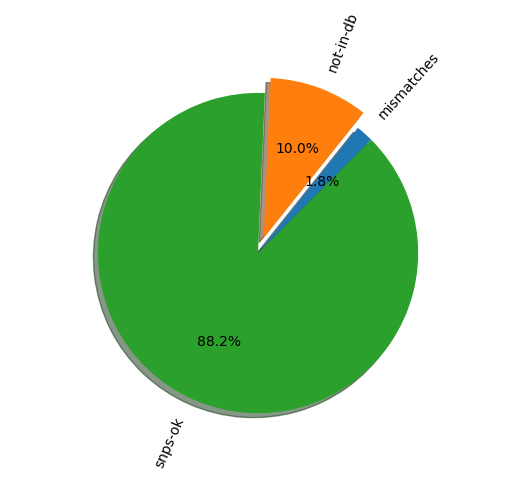

In [12]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['mismatches', 'not-in-db', 'snps-ok']
sizes = [len(mismatches_ars1), len(missing_ars1), VariantGoat.objects.count()-len(mismatches_ars1)]
explode = (0, 0.1, 0)  # only "explode" the 2nd slice (i.e. 'Not-in-db')

fig2, ax2 = plt.subplots()
ax2.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=45, rotatelabels=45)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Get some samples from missing and mismatches SNPs. The full list of those are written in a CSV file:

In [13]:
print("Get some missing SNPs as an example:")
random.seed(a=42, version=2)
print([record.locus_name for record in random.sample(missing_chi1, 20)])

Get some missing SNPs as an example:
['snp53232-scaffold802-302292', 'snp8623-scaffold131-1957741', 'snp2142-scaffold1065-346259', 'snp57899-scaffold937-945284', 'snp22751-scaffold2269-23307', 'snp20886-scaffold205-1652913', 'snp19319-scaffold1951-805', 'snp11414-scaffold1413-197984', 'snp57720-scaffold93-372964', 'snp7830-scaffold1281-1591810', 'snp55420-scaffold858-1840765', 'snp57833-scaffold932-648576', 'snp45755-scaffold628-186886', 'snp6063-scaffold1214-225045', 'snp49844-scaffold711-2905467', 'snp34187-scaffold401-1192271', 'snp2887-scaffold1086-820658', 'snp2545-scaffold1074-1086687', 'snp6823-scaffold125-1330098', 'snp19054-scaffold1912-898736']


In [14]:
random.seed(a=42, version=2)
selected_ars1 = random.sample(mismatches_ars1, 20)

# get rs_id from selected items
selected_rsID = [",".join(variant.rs_id) for (record, variant) in selected_ars1 if variant.rs_id]

# get informations from ensembl
result_ars1 = ensRest.getVariationByMultipleIds(ids=selected_rsID, species="capra_hircus")

In [15]:
def to_pd_table(selected, result):
    data = defaultdict(list)

    for record, variant in selected:
        # rs_id is now a list of rs_ids
        rs_ids = ",".join(variant.rs_id)
        
        data["entry"].append(record.locus_name)
        data["rs_"].append(record.rs_)
        data["chrom"].append(record.ars1_chr)
        data["pos"].append(record.ars1_pos)
        data["rs_ids"].append(rs_ids)
        data["smarter_chrom"].append(variant.locations[0].chrom)
        data["smarter_pos"].append(variant.locations[0].position)

        if variant.rs_id and not 'failed' in result[rs_ids]:
            data["ensembl_chrom"].append(result[rs_ids]['mappings'][0]['seq_region_name'])
            data["ensembl_pos"].append(result[rs_ids]['mappings'][0]['start'])

        else:
            data["ensembl_chrom"].append(None)
            data["ensembl_pos"].append(None)
                
        if 'failed' in result[rs_ids]:
            data["ensembl_failed"].append(result[rs_ids]['failed'])
        
        else:
            data["ensembl_failed"].append(None)

    return pandas.DataFrame.from_dict(data)

to_pd_table(selected_ars1, result_ars1)

,entry,rs_,chrom,pos,rs_ids,smarter_chrom,smarter_pos,ensembl_chrom,ensembl_pos,ensembl_failed
0,snp10978-scaffold13932-19256,rs268243822,18,64350718,rs268243822,18,64495025,None,NaN,Variant does not map to the genome
1,snp2720-scaffold1079-655080,rs268235776,Unknown,20183,rs268235776,0.NW_scaffold,20183,7,92001864.0,None
2,snp24769-scaffold2530-14952,rs268257162,Unknown,36932,rs268257162,0.NW_scaffold,9829,None,NaN,Variant does not map to the genome
3,snp22886-scaffold228-4649518,rs268255332,Unknown,372155,rs268255332,0.NW_scaffold,372155,None,NaN,Variant does not map to the genome
4,snp21494-scaffold21-244274,rs268253976,14,-1,rs268253976,null,0,None,NaN,Variant does not map to the genome
5,snp13706-scaffold153-960292,rs268246476,Unknown,858874,rs268246476,0.NW_scaffold,858874,None,NaN,Variant does not map to the genome
6,snp8812-scaffold1316-38259,rs268241723,Unknown,160485,rs268241723,0.NW_scaffold,160485,None,NaN,Variant does not map to the genome
7,snp58664-scaffold956-522857,rs268290160,13,71181569,rs268290160,13,71187835,None,NaN,Variant maps to more than one genomic location
8,snp7608-scaffold1271-347413,rs268240542,Unknown,146208,rs268240542,0.NW_scaffold,146208,None,NaN,Variant does not map to the genome
9,snp37951-scaffold47-1337018,rs268270029,Unknown,57698,rs268270029,0.NW_scaffold,57698,None,NaN,Variant does not map to the genome


There are few mismatches from received coordinates and the data I have in the database. However, the smarter data comes from the latest chip so I belive I can trust it. There are some considerations to made about SNP placement: I thick I need to cross-check with ensembl and try to align the probe myself to understand if there are issues on chip placement

<a id='check-mismatches-with-ensembl'></a>
### Check mismatches with ensembl

Define other useful stuff:

In [16]:
# https://www.delftstack.com/it/howto/python/python-split-list-into-chunks/
def group_elements(lst, chunk_size):
    """Divide a list in chunks"""
    
    lst = iter(lst)
    return iter(lambda: tuple(islice(lst, chunk_size)), ())

Ok, now divide data in chunks (all mismatches) and do a request to EnsEMBL. Track results in *dataframes*

In [17]:
data = []

for chunk in group_elements(mismatches_ars1, 50):
    # get rs_id
    chunk_rsIDs = [",".join(variant.rs_id) for (record, variant) in chunk if variant.rs_id]
    
    # get informations from ensembl
    chunk_ensembl = ensRest.getVariationByMultipleIds(ids=chunk_rsIDs, species="capra_hircus")
    
    # transform informations in dataframe
    data.append(to_pd_table(chunk, chunk_ensembl))
    
ensembl_result = pandas.concat(data)

Track all mismatches with the values read from ensembl

In [18]:
ensembl_result.to_excel(result_dir / "iggc_vs_smarter-mismatches-ars1.xlsx", index=False)

In [19]:
ensembl_result

,entry,rs_,chrom,pos,rs_ids,smarter_chrom,smarter_pos,ensembl_chrom,ensembl_pos,ensembl_failed
0,snp130-scaffold100-2425437,rs268233269,15,73927990,rs268233269,0.NW_scaffold,18738,15,73927990.0,None
1,snp131-scaffold100-2465624,rs268233270,Unknown,10318,rs268233270,15,73882882,15,73882882.0,None
2,snp209-scaffold1004-554785,rs268233343,3,67100128,rs268233343,3,67100127,None,NaN,Variant does not map to the genome
3,snp217-scaffold1004-859671,rs268233350,3,66796894,rs268233350,0.NW_scaffold,8021,3,66796894.0,None
4,snp481-scaffold1012-17285,rs268233607,X,64671247,rs268233607,null,0,None,NaN,Variant does not map to the genome
...,...,...,...,...,...,...,...,...,...,...
29,snp33783-scaffold398-31480,rs268292396,X,60920403,rs268292396,null,0,None,NaN,Variant does not map to the genome
30,snp41567-scaffold5407-5726,rs268292587,6,115801932,rs268292587,3,26509044,None,NaN,Variant does not map to the genome
31,snp50146-scaffold717-3171702,rs268292827,Unknown,5104,rs268292827,12,61977299,12,61977299.0,None
32,snp56708-scaffold897-410739,rs268293003,Unknown,4602,rs268293003,0.NW_scaffold,4602,None,NaN,Variant does not map to the genome
